In [87]:
#Diving deep into quantum circuits
#importing libraries 
import asyncio # a library to write concurrent code using the async/await syntax.
import matplotlib.pyplot as plt
#magic word for producing visualizations in notebook
%matplotlib inline
import string
from datetime import datetime
import logging #to store information about your script and track events that occur


#AWS imports : Importing braket SDK modules
from braket.circuits import Circuit,Gate,Instruction, circuit, Observable,FreeParameter
from braket.circuits.serialization import IRType #The IR format is used to represent the circuit in a way that can be easily translated to other formats, such as OpenQASM, which is a widely used quantum assembly language.
from braket.aws import AwsDevice,AwsQuantumTask
from braket.devices import LocalSimulator 

In [88]:
#DEFINING A CIRCUIT WITH 4 QUBITS
my_circuit = Circuit().h(range(4)).cnot(control=0,target = 2).cnot(1,3)
print(my_circuit)

T  : |0| 1 |
            
q0 : -H-C---
        |   
q1 : -H-|-C-
        | | 
q2 : -H-X-|-
          | 
q3 : -H---X-

T  : |0| 1 |


In [89]:
# show moments of our quantum circuit
my_moments = my_circuit.moments
for moment in my_moments:
    print(moment)

MomentsKey(time=0, qubits=QubitSet([Qubit(0)]), moment_type=<MomentType.GATE: 'gate'>, noise_index=0)
MomentsKey(time=0, qubits=QubitSet([Qubit(1)]), moment_type=<MomentType.GATE: 'gate'>, noise_index=0)
MomentsKey(time=0, qubits=QubitSet([Qubit(2)]), moment_type=<MomentType.GATE: 'gate'>, noise_index=0)
MomentsKey(time=0, qubits=QubitSet([Qubit(3)]), moment_type=<MomentType.GATE: 'gate'>, noise_index=0)
MomentsKey(time=1, qubits=QubitSet([Qubit(0), Qubit(2)]), moment_type=<MomentType.GATE: 'gate'>, noise_index=0)
MomentsKey(time=1, qubits=QubitSet([Qubit(1), Qubit(3)]), moment_type=<MomentType.GATE: 'gate'>, noise_index=0)


In [90]:
# list all instructions/gates making up our circuit
my_instructions = my_circuit.instructions
for instruction in my_instructions:
    print(instruction)

Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1)
Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1)
Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(2)]), 'control': QubitSet([]), 'control_state': (), 'power': 1)
Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(3)]), 'control': QubitSet([]), 'control_state': (), 'power': 1)
Instruction('operator': CNot('qubit_count': 2), 'target': QubitSet([Qubit(0), Qubit(2)]), 'control': QubitSet([]), 'control_state': (), 'power': 1)
Instruction('operator': CNot('qubit_count': 2), 'target': QubitSet([Qubit(1), Qubit(3)]), 'control': QubitSet([]), 'control_state': (), 'power': 1)


In [91]:
#Defining the circuit with parameterized gates
my_circuit =Circuit().rx(0,0.15).ry(1,0.2).rz(2,0.25).h(3).cnot(control=0,target=2).cnot(1,3).x([1,3])
print(my_circuit)

T  : |   0    | 1 |2|
                     
q0 : -Rx(0.15)-C-----
               |     
q1 : -Ry(0.20)-|-C-X-
               | |   
q2 : -Rz(0.25)-X-|---
                 |   
q3 : -H----------X-X-

T  : |   0    | 1 |2|


In [92]:
#designing gates with free parameters and and free parameters
alpha = FreeParameter('alpha')
beta = FreeParameter('beta')
gamma = FreeParameter('gamma')
my_circuit = Circuit().rx(0, alpha).ry(1,beta).rz(2,gamma).h(3).cnot(0,2).cnot(1,3).x([1,3])
print(my_circuit)

T  : |    0    | 1 |2|
                      
q0 : -Rx(alpha)-C-----
                |     
q1 : -Ry(beta)--|-C-X-
                | |   
q2 : -Rz(gamma)-X-|---
                  |   
q3 : -H-----------X-X-

T  : |    0    | 1 |2|

Unassigned parameters: [alpha, beta, gamma].


In [93]:
#Printing all available gates currently available within SDK
gate_set=[attr for attr in dir(Gate) if attr[0] in string.ascii_uppercase]
print(gate_set)

['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CV', 'CY', 'CZ', 'ECR', 'GPi', 'GPi2', 'H', 'I', 'ISwap', 'MS', 'PSwap', 'PhaseShift', 'PulseGate', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']


In [94]:
#HELPER function to build a custom gate 
def u3(alpha,theta,phi):
    """"
     function to return matrix for general single qubit rotation
    rotation is given by exp(-i sigma*n/2*alpha) where alpha is rotation angle
    and n defines rotation axis as n=(sin(theta)cos(phi), sin(theta)sin(phi), cos(theta))
    sigma is vector of Pauli matrices
    """
    u11 = np.cos(alpha/2)-1j*np.sin(alpha/2)*np.cos(theta)
    u12 = -1j*(np.exp(-1j*phi))*np.sin(theta)*np.sin(alpha/2)
    u21 = -1j*(np.exp(1j*phi))*np.sin(theta)*np.sin(alpha/2)
    u22 = np.cos(alpha/2)+1j*np.sin(alpha/2)*np.cos(theta)
    
    return np.array([[u11 , u12], [u21 ,u22]])


In [95]:
# define the print custom unitary 
import numpy as np
my_u3 = u3(np.pi/2, 0, 0)
print(my_u3)

#example circuit applying custom U to the first qubit
circ = Circuit().unitary(matrix = my_u3, targets=[0]).h(1).cnot(0,1)
print()
print(circ)

[[0.70710678-0.70710678j 0.        +0.j        ]
 [0.        +0.j         0.70710678+0.70710678j]]

T  : |0|1|
          
q0 : -U-C-
        | 
q1 : -H-X-

T  : |0|1|


In [96]:
#helper function to build custom gate 
@circuit.subroutine(register=True) # it's a subroutine and @ is called decorator for modifying the subroutine

def u3(target,angles):
    """
    Function to return the matrix for a general single qubit rotation,
    given by exp(-i sigma*n/2*alpha), where alpha is the rotation angle,
    n defines the rotation axis via n=(sin(theta)cos(phi), sin(theta)sin(phi), cos(theta)),
    and sigma is the vector of Pauli matrices
    """
    #get angles
    alpha = angles[0]
    theta = angles[1]
    phi = angles[2]
    
    #set 2x2 matrix entries
    u11 = np.cos(alpha/2)-1j*np.sin(alpha/2)*np.cos(theta)
    u12 = -1j*(np.exp(-1j*phi))*np.sin(theta)*np.sin(alpha/2)
    u21 = -1j*(np.exp(1j*phi))*np.sin(theta)*np.sin(alpha/2)
    u22 = np.cos(alpha/2)+1j*np.sin(alpha/2)*np.cos(theta)

    #define unitary as numpy matrix
    u = np.array([[u11,u12], [u21,u22]])
    print('Unitary: ', u)
    print()
    print()
    
    #define custom Braket gate 
    circ = Circuit()
    circ.unitary(matrix=u, targets=target)
    
    return circ
    
    

In [97]:
# define example circuit applying custom single-qubit gate U to the first qubit
angles = [np.pi/2, np.pi/2, np.pi/2]
angles = [np.pi/4, 0, 0]

# build circuit using custom u3 gate
circ2 = Circuit().u3([0], angles).cnot(0,1)
print(circ2)

Unitary:  [[0.92387953-0.38268343j 0.        +0.j        ]
 [0.        +0.j         0.92387953+0.38268343j]]


T  : |0|1|
          
q0 : -U-C-
        | 
q1 : ---X-

T  : |0|1|


In [98]:
#CIRCUIT DEPTH AND CIRCUIT SIZE
#We can get the circuit depth (the number of moments defining our circuit) with ```circuit.depth``` 

#DEFINING CIRCUIT WITH PARAMETRIZED GATES
my_circuit = Circuit().rx(0,0.15).ry(1,0.2).rz(2, 0.25).h(3).cnot(0,2).cnot(1,3).x(0)
circuit_depth = my_circuit.depth
print(my_circuit)
print()
print('Total circuit depth:', circuit_depth)


T  : |   0    | 1 |2|
                     
q0 : -Rx(0.15)-C---X-
               |     
q1 : -Ry(0.20)-|-C---
               | |   
q2 : -Rz(0.25)-X-|---
                 |   
q3 : -H----------X---

T  : |   0    | 1 |2|

Total circuit depth: 3


In [99]:
# defining circuit with parameterized gates 
my_circuit = Circuit().rx(0, 0.15).ry(1, 0.2).rz(2, 0.25).h(3).cnot(control=0, target=2).cnot(1, 3).x(4)
# getting circuit depth
circuit_depth = my_circuit.depth
# get qubit number
qubit_count = my_circuit.qubit_count
# getting approx. estimate of circuit size
circuit_size = circuit_depth*qubit_count
# printing circuit
print(my_circuit)
print()
# printing characteristics of our circuit
print('Total circuit depth:', circuit_depth)
print('Number of qubits:', qubit_count)
print('Circuit size:', circuit_size)

T  : |   0    | 1 |
                   
q0 : -Rx(0.15)-C---
               |   
q1 : -Ry(0.20)-|-C-
               | | 
q2 : -Rz(0.25)-X-|-
                 | 
q3 : -H----------X-
                   
q4 : -X------------

T  : |   0    | 1 |

Total circuit depth: 2
Number of qubits: 5
Circuit size: 10


                                      APPENDING CIRCUITS
We can extend existing circuits by adding instructions or just appending circuits to each other, as shown below. In the most simple and straightforward fashion we can just append gates to existing circuits (for example, ```my_circuit.y(4)```). 

In [100]:
#SIMPLE CIRCUIT EXPTENSION BY APPENDING GATES ( Y ON QUBIT 4)
my_circuit = my_circuit.y(4)
# updating circuit depth , circuit count , circuit size
circuit_depth = my_circuit.depth
qubit_count = my_circuit.qubit_count

circuit_size = circuit_depth*qubit_count
print(my_circuit)
print()
print('Total circuit depth:', circuit_depth)
print('Number of qubits:', qubit_count)
print('Circuit size:', circuit_size)

T  : |   0    | 1 |
                   
q0 : -Rx(0.15)-C---
               |   
q1 : -Ry(0.20)-|-C-
               | | 
q2 : -Rz(0.25)-X-|-
                 | 
q3 : -H----------X-
                   
q4 : -X--------Y---

T  : |   0    | 1 |

Total circuit depth: 2
Number of qubits: 5
Circuit size: 10


In [101]:
#Alternatively, we can define a gate as an Instruction and use the add_instruction(...) 
#method to add this gate to an existing circuit object.


In [102]:
    # INSTRUCTION TO CIRCUIT
    gate_instr = Instruction(Gate.CNot(),[0,1])
    my_circuit = my_circuit.add_instruction(gate_instr)
    # updating circuit depth , circuit count , circuit size
    circuit_depth = my_circuit.depth
    qubit_count = my_circuit.qubit_count

    circuit_size = circuit_depth*qubit_count
    print(my_circuit)
    print()
    print('Total circuit depth:', circuit_depth)
    print('Number of qubits:', qubit_count)
    print('Circuit size:', circuit_size)

T  : |   0    | 1 |2|
                     
q0 : -Rx(0.15)-C---C-
               |   | 
q1 : -Ry(0.20)-|-C-X-
               | |   
q2 : -Rz(0.25)-X-|---
                 |   
q3 : -H----------X---
                     
q4 : -X--------Y-----

T  : |   0    | 1 |2|

Total circuit depth: 3
Number of qubits: 5
Circuit size: 15


In [103]:
# add instruction to circuit
gate_instr = Instruction(Gate.CNot(), [0, 1])
my_circuit = my_circuit.add_instruction(gate_instr)
# get circuit depth
circuit_depth = my_circuit.depth
# get qubit number
qubit_count = my_circuit.qubit_count
# get circuit size
circuit_size = circuit_depth*qubit_count
# print circuit
print(my_circuit)
print()
print('Total circuit depth:', circuit_depth)
print('Number of qubits:', qubit_count)
print('Circuit size:', circuit_size)

T  : |   0    | 1 |2|3|
                       
q0 : -Rx(0.15)-C---C-C-
               |   | | 
q1 : -Ry(0.20)-|-C-X-X-
               | |     
q2 : -Rz(0.25)-X-|-----
                 |     
q3 : -H----------X-----
                       
q4 : -X--------Y-------

T  : |   0    | 1 |2|3|

Total circuit depth: 4
Number of qubits: 5
Circuit size: 20


In [104]:
# add instruction to circuit
gate_instr = Instruction(Gate.CNot(), [0, 1])
my_circuit = my_circuit.add_instruction(gate_instr)
# get circuit depth
circuit_depth = my_circuit.depth
# get qubit number
qubit_count = my_circuit.qubit_count
# get circuit size
circuit_size = circuit_depth*qubit_count
# print circuit
print(my_circuit)
print()
print('Total circuit depth:', circuit_depth)
print('Number of qubits:', qubit_count)
print('Circuit size:', circuit_size)

T  : |   0    | 1 |2|3|4|
                         
q0 : -Rx(0.15)-C---C-C-C-
               |   | | | 
q1 : -Ry(0.20)-|-C-X-X-X-
               | |       
q2 : -Rz(0.25)-X-|-------
                 |       
q3 : -H----------X-------
                         
q4 : -X--------Y---------

T  : |   0    | 1 |2|3|4|

Total circuit depth: 5
Number of qubits: 5
Circuit size: 25


In [105]:
#WE CAN APPEND TWO CIRCUITS WITH add_function()

In [106]:
#appending two circuits with add_circuit() functionality 
my_circuit2= Circuit().rz(0,0.1).rz(1,0.2).rz(3,0.3).rx(4,0.4)
my_circuit.add_circuit(my_circuit2)

# get circuit depth
circuit_depth = my_circuit.depth
# get qubit number
qubit_count = my_circuit.qubit_count
# get circuit size
circuit_size = circuit_depth*qubit_count
# print circuit
print(my_circuit)
print()
# print characteristics of our circuit
print('Total circuit depth:', circuit_depth)
print('Number of qubits:', qubit_count)
print('Circuit size:', circuit_size)

T  : |   0    | 1 |   2    |3|4|   5    |
                                         
q0 : -Rx(0.15)-C---C--------C-C-Rz(0.10)-
               |   |        | |          
q1 : -Ry(0.20)-|-C-X--------X-X-Rz(0.20)-
               | |                       
q2 : -Rz(0.25)-X-|-----------------------
                 |                       
q3 : -H----------X-Rz(0.30)--------------
                                         
q4 : -X--------Y---Rx(0.40)--------------

T  : |   0    | 1 |   2    |3|4|   5    |

Total circuit depth: 6
Number of qubits: 5
Circuit size: 30


In [107]:
## CIRCUIT EXECUTION AND QUANTUM TASK TRACKING

# Create the device. The experiment value must be unique among any devices in use at the tim
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

# set up the device to be the Rigetti quantum computer
# device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3")

# set up the device to be the IonQ quantum computer
# device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Harmony")

# set up the device to be the Oxford Quantum Circuits (OQC) quantum computer
# device = AwsDevice("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")



In [108]:
#CHECKING THE SET OF GATES THE DEVICE SUPPORTS


In [109]:
#showing the properties of device
device_properties = device.properties

#to show supportedQuantumOperations ( supported gates for a device)
device_operations = device_properties.dict()['action']['braket.ir.jaqcd.program']['supportedOperations']

#This field also exists for other devices like QPUs
print('The Quantum Gates supported by this device are:\t \n',device_operations)

The Quantum Gates supported by this device are:	 
 ['ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'cy', 'cz', 'ecr', 'h', 'i', 'iswap', 'pswap', 'phaseshift', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'unitary', 'v', 'vi', 'x', 'xx', 'xy', 'y', 'yy', 'z', 'zz']


In [110]:
'''POLLING PARAMETERS: With the run(...) method we can set two important parameters:
•	poll_timeout_seconds is the number of seconds you want to wait and poll the task before it times out; the default value is 5 days (that is ∼5∗60∗60∗24∼5∗60∗60∗24 seconds).
•	poll_interval_seconds is the frequency how often the task is polled, e.g., how often you call the Braket API to get the status; the default value is 1 second.'''


'POLLING PARAMETERS: With the run(...) method we can set two important parameters:\n•\tpoll_timeout_seconds is the number of seconds you want to wait and poll the task before it times out; the default value is 5 days (that is ∼5∗60∗60∗24∼5∗60∗60∗24 seconds).\n•\tpoll_interval_seconds is the frequency how often the task is polled, e.g., how often you call the Braket API to get the status; the default value is 1 second.'

ID of quantum task: arn:aws:braket:us-east-1:666089549503:quantum-task/7a19c6b0-cbbc-477f-8e9b-fcb720eed033
Status of quantum task: CREATED
Status: CREATED
Status: CREATED
Status: CREATED
Status: CREATED
Status: QUEUED
Status: QUEUED
Status: QUEUED
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: COMPLETED
Counter({'00010': 500, '00000': 448, '00001': 18, '00011': 18, '01000': 5, '11110': 4, '11100': 4, '01010': 3})


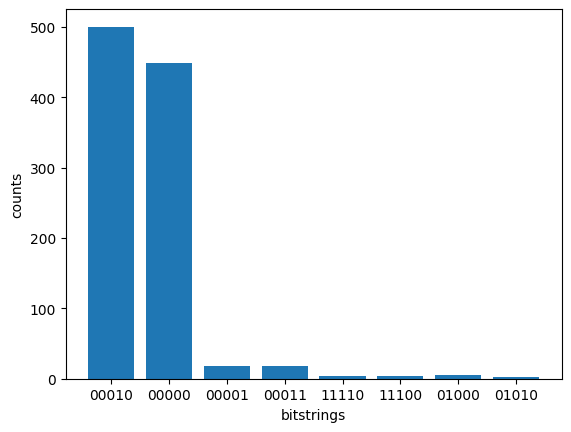

In [111]:
#defining the quantum task(asynchronous)
task = device.run(my_circuit,poll_timeout_seconds = 100, shots=1000)

#get id and status of submitted quantum task
task_id = task.id 
status = task.state()
print('ID of quantum task:', task_id)
print('Status of quantum task:', status)

#waiting for the job to complete
while status != 'COMPLETED':
    status = task.state()
    print('Status:',status)

#getting results of quantum task
result = task.result()

#get measurement shots
counts = result.measurement_counts

#printing counts 
print(counts)

#plot using counter
plt.bar(counts.keys(),counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

In [112]:
'''The on-demand simulators SV1 and DM1 also support 
running parametrized tasks. The value of any free parameters can be fixed when 
the circuit is run using the optional `inputs` argument to `run`. `inputs` should be 
a `dict` of `string`-`float` pairs.'''

'The on-demand simulators SV1 and DM1 also support \nrunning parametrized tasks. The value of any free parameters can be fixed when \nthe circuit is run using the optional `inputs` argument to `run`. `inputs` should be \na `dict` of `string`-`float` pairs.'

T  : |    0    | 1 |2|
                      
q0 : -Rx(alpha)-C-----
                |     
q1 : -Ry(beta)--|-C-X-
                | |   
q2 : -Rz(gamma)-X-|---
                  |   
q3 : -H-----------X-X-

T  : |    0    | 1 |2|

Unassigned parameters: [alpha, beta, gamma].
Status of quantum task: CREATED
Status: CREATED
Status: CREATED
Status: CREATED
Status: CREATED
Status: CREATED
Status: CREATED
Status: QUEUED
Status: QUEUED
Status: QUEUED
Status: QUEUED
Status: QUEUED
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: COMPLETED
Counter({'0101': 500, '0100': 487, '0001': 8, '0000': 3, '1111': 1, '1110': 1})


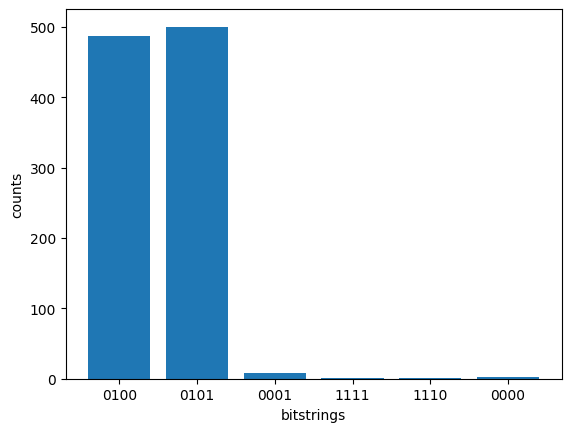

In [113]:
#Defining circuit with some parametrized gates and free parameters
alpha = FreeParameter('alpha')
beta = FreeParameter('beta')
gamma = FreeParameter('gamma')
my_circuit = Circuit().rx(0, alpha).ry(1, beta).rz(2, gamma).h(3).cnot(control=0, target=2).cnot(1, 3).x([1,3])
print(my_circuit)
# define quantum task (asynchronous)
task = device.run(my_circuit, 
                  poll_timeout_seconds = 100, 
                  shots=1000, inputs={'alpha': 0.1, 'beta': 0.2, 'gamma': 0.3})

# get id and status of submitted quantum task
task_id = task.id
status = task.state()
# print('ID of quantum task:', task_id)
print('Status of quantum task:', status)

# wait for job to complete
while status != 'COMPLETED':
    status = task.state()
    print('Status:', status)

# get results of task
result = task.result()

# get measurement shots
counts = result.measurement_counts

# print counts
print(counts)

# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

In [135]:
'''TASK METADATA: You can access a range of metadata associated with your task object, as shown below.'''

'TASK METADATA: You can access a range of metadata associated with your task object, as shown below.'

In [115]:
#Getting metadata of all submitted quantum-task
metadata = task.metadata()
# metadata example
shots = metadata['shots']
date = metadata['ResponseMetadata']['HTTPHeaders']['date']
print("shots" , shots)
print("date", date)
# print example metadata
print("{} shots taken on {} ".format(shots,date))

shots 1000
date Thu, 05 Oct 2023 05:12:13 GMT
1000 shots taken on Thu, 05 Oct 2023 05:12:13 GMT 


In [116]:
                                  '''  TASK RECONSTRUCTION 
 When kernel dies after you have submitted the task, 
 or you simply close your notebook. As recovery method, here 
 is how you can reconstruct the ```task``` object (given the corresponding unique arn). 
 You can reconstruct the ```task``` object using `
 task = AwsQuantumTask(arn=...)`; then you can simply call `task.result()` to get 
 the result from S3. '''
  


'  TASK RECONSTRUCTION \n When kernel dies after you have submitted the task, \n or you simply close your notebook. As recovery method, here \n is how you can reconstruct the ```task``` object (given the corresponding unique arn). \n You can reconstruct the ```task``` object using `\n task = AwsQuantumTask(arn=...)`; then you can simply call `task.result()` to get \n the result from S3. '

In [117]:
# Restoring quantum task from unique arn 
task_load = AwsQuantumTask(arn = task_id)
#print status
status = task_load.state()
print('Status of (reconstructed) quantum task:', status)

Status of (reconstructed) quantum task: COMPLETED


Counter({'0101': 500, '0100': 487, '0001': 8, '0000': 3, '1111': 1, '1110': 1})


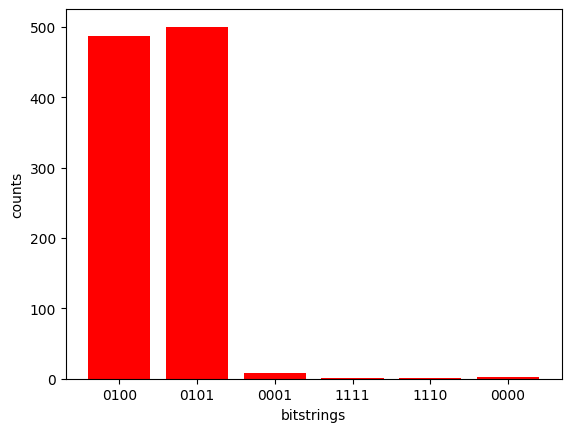

In [118]:
#getting result of quantum task
result = task_load.result()


#to get measurement shors
shots = result.measurement_counts

#to print counts
print(counts)

#plot using counter
plt.bar(counts.keys(),counts.values(),color='r');
plt.xlabel('bitstrings');
plt.ylabel('counts');

In [119]:
''' Using cancel()  method to cancel the existing task '''


' Using cancel()  method to cancel the existing task '

In [120]:
# defining quantum task 
task = device.run(my_circuit, shots=1000,inputs = {'alpha':0.1, 'beta':0.2,'gamma': 0.3})

#to get id and status of quantum task 
task_id = task.id
status = task.state()

print ("ID of quantum task : " , task_id )
print("status of quantum task : ",status) 
#cancelling the task 
task.cancel()
status = task.state()
print('status of quantum task :',status)

ID of quantum task :  arn:aws:braket:us-east-1:666089549503:quantum-task/c2545ca2-19d1-4f65-bca3-5192848d9502
status of quantum task :  CREATED
status of quantum task : CANCELLING


In [121]:
'''DEMONSTRATION OF RESULT TYPES: Expectation Values and Observables'''

'DEMONSTRATION OF RESULT TYPES: Expectation Values and Observables'

In [122]:
'''So far, we have only taken measurements in the computational basis. However, 
it is also possible to measure in other bases, as well as estimate important statistics 
like expectation value and variance. We do this by adding ResultTypes to our circuit; in the 
following example, we will make measurements in the basis of the observable  𝑋0𝑌1
  (this is the tensor product  𝑋(0)⊗𝑌(1)):'''

'So far, we have only taken measurements in the computational basis. However, \nit is also possible to measure in other bases, as well as estimate important statistics \nlike expectation value and variance. We do this by adding ResultTypes to our circuit; in the \nfollowing example, we will make measurements in the basis of the observable  𝑋0𝑌1\n  (this is the tensor product  𝑋(0)⊗𝑌(1)):'

In [123]:
#defining example circuit
circ = Circuit().rx(0,0.15).ry(1,0.2).rz(2,0.25).h(3).cnot(0,2).cnot(1,3).x(4)
#adding expectation value
obs = Observable.X() @ Observable.Y()
target_qubits = [0,1]
circ.expectation(obs , target = target_qubits)
# adding variance
circ.variance(obs , target= target_qubits)
#adding sample

circ.sample(obs, target = target_qubits)
print(circ)


T  : |   0    | 1 |               Result Types               |
                                                              
q0 : -Rx(0.15)-C---Expectation(X@Y)-Variance(X@Y)-Sample(X@Y)-
               |   |                |             |           
q1 : -Ry(0.20)-|-C-Expectation(X@Y)-Variance(X@Y)-Sample(X@Y)-
               | |                                            
q2 : -Rz(0.25)-X-|--------------------------------------------
                 |                                            
q3 : -H----------X--------------------------------------------
                                                              
q4 : -X-------------------------------------------------------

T  : |   0    | 1 |               Result Types               |


In [137]:
'''Sample is only valid when shots>0

As shown above, results types are part of the print information. 
We now run this circuit on the local simulator above and output these results.'''

'Sample is only valid when shots>0\n\nAs shown above, results types are part of the print information. \nWe now run this circuit on the local simulator above and output these results.'

In [125]:
#setting up device
device = LocalSimulator()
#run the circuit and output the results specified above
task = device.run(circ,shots  = 100)
result = task.result()
print("Expectation value for <X0*Y1>:", result.values[0])
print("Variance for <X0*Y1>:", result.values[1])
print("Measurement samples for X0*Y1 :",result.values[2])

Expectation value for <X0*Y1>: 0.08
Variance for <X0*Y1>: 0.9935999999999998
Measurement samples for X0*Y1 : [-1. -1.  1. -1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.
 -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.
 -1.  1. -1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.
  1.  1. -1. -1. -1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1.
  1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.  1. -1.
 -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.]


In [138]:
''' TO VERIFY THAT WE GET THE SAME 
ESTIMATE FOR THE EXPECTATION VALUE IF WE COMPUTE IT BY HAND FROM THE SAMPLES'''

' TO VERIFY THAT WE GET THE SAME \nESTIMATE FOR THE EXPECTATION VALUE IF WE COMPUTE IT BY HAND FROM THE SAMPLES'

In [127]:
samples = result.values[2]
sum_of_samples = samples.sum()
total_counts = len(samples)
expect_from_samples = sum_of_samples / total_counts
print('Expectation value from samples :', expect_from_samples)

Expectation value from samples : 0.08


In [129]:
'''So far, we have measured only one observable, namely  𝑋0𝑌1
 . However, it is possible to measure multiple observables at once, provided that any observables with overlapping qubits have the same factor acting on each qubit:'''

'So far, we have measured only one observable, namely  𝑋0𝑌1\n . However, it is possible to measure multiple observables at once, provided that any observables with overlapping qubits have the same factor acting on each qubit:'

In [132]:
circ = Circuit().rx(0,0.15).ry(1,0.2).rz(2,0.25).h(3).cnot(0,2).cnot(1,3).x(4)
circ.expectation(Observable.X() @ Observable.Y(), target=[0,1])
circ.expectation(Observable.Z() @ Observable.H(), target =[2,4])
# Overlaps on qubits 1 and 4, but Y and H are the same factors 
#that have been applied to each, respectively
circ.expectation(Observable.Y() @ Observable.X() @ Observable.H(), target=[1,3,4])

print(circ)
#run circuit
task = device.run(circ, shots = 1000)
result = task.result()
print('EXPECTATION VALUE FOR <X0*Y1>: ' ,result.values[0])
print('EXPECTATION VALUE FOR <Z2*H4>: ' ,result.values[1])
print("Expectation value for <Y1*X3*H4>:: ",result.values[2])

T  : |   0    | 1 |           Result Types            |
                                                       
q0 : -Rx(0.15)-C---Expectation(X@Y)--------------------
               |   |                                   
q1 : -Ry(0.20)-|-C-Expectation(X@Y)-Expectation(Y@X@H)-
               | |                  |                  
q2 : -Rz(0.25)-X-|-Expectation(Z@H)-|------------------
                 | |                |                  
q3 : -H----------X-|----------------Expectation(Y@X@H)-
                   |                |                  
q4 : -X------------Expectation(Z@H)-Expectation(Y@X@H)-

T  : |   0    | 1 |           Result Types            |
EXPECTATION VALUE FOR <X0*Y1>:  -0.04
EXPECTATION VALUE FOR <Z2*H4>:  -0.71
Expectation value for <Y1*X3*H4>::  0.062


In [133]:
''' This is possible because we only need to measure in at most one basis 
for each qubit. For instance in the example above, on qubit 1 we only measure in the Y basis. '''

' This is possible because we only need to measure in at most one basis \nfor each qubit. For instance in the example above, on qubit 1 we only measure in the Y basis. '

In [134]:
'''In all examples discussed so far we have set the parameter shots>0, thereby 
mimicking the behavior of actual quantum hardware. However, on a classical 
simulator we do have access to the full state vector when shots=0. 
We will illustrate this functionality in more detail in this section. '''

'In all examples discussed so far we have set the parameter shots>0, thereby \nmimicking the behavior of actual quantum hardware. However, on a classical \nsimulator we do have access to the full state vector when shots=0. \nWe will illustrate this functionality in more detail in this section. '